<center><h1>Shah_IshitaSandip_Project</h1></center>

Name: Ishita Sandip Shah
<br>
Github Username: ishi0801
<br>
USC ID: 5275336162

In [ ]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import random

import zipfile
import os

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0, VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


In [ ]:
# Specify the path to the ZIP file and destination directory
# zfs = '/content/drive/MyDrive/data.zip'
# dest = '/content'

# with zipfile.ZipFile(zfs, 'r') as zr:
#     zr.extractall(dest)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [ ]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [ ]:
def augment_image_opencv(image):
    # OpenCV-based image augmentation
    angle = random.uniform(-15, 15)
    scale = random.uniform(0.8, 1.2)
    flip = random.choice([False, True])
    translate_x = random.uniform(-20, 20)
    translate_y = random.uniform(-20, 20)

    # Rotate
    M_rotate = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, scale)
    image = cv2.warpAffine(image, M_rotate, (image.shape[1], image.shape[0]), borderMode=cv2.BORDER_REFLECT)

    # Flip
    if flip:
        image = cv2.flip(image, 1)

    # Translate
    M_translate = np.float32([[1, 0, translate_x], [0, 1, translate_y]])
    image = cv2.warpAffine(image, M_translate, (image.shape[1], image.shape[0]), borderMode=cv2.BORDER_REFLECT)

    return image

def load_and_preprocess(img_loc, label, is_training):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')
        img = tf.image.resize(img, (299, 299))
        img = np.array(img)

        # Apply image augmentation only during training
        if is_training:
            img = augment_image_opencv(img)

        return img, 1 if label_str == 'frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape((299, 299, 3))  # Set the shape of the image tensor
    y.set_shape(())  # Set the shape of the label tensor

    return X, y



def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(lambda x, y: load_and_preprocess(x, y, is_training=True), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)


random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(lambda x, y: load_and_preprocess(x, y, is_training=False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(lambda x, y: load_and_preprocess(x, y, is_training=False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

#### c) CNN+MLP

Epoch 1/20
928/928 [==============================] - 191s 203ms/step - loss: 9.2058 - accuracy: 0.6637 - val_loss: 3.7503 - val_accuracy: 0.8795
Epoch 2/20
928/928 [==============================] - 192s 207ms/step - loss: 3.7688 - accuracy: 0.7029 - val_loss: 8.2093 - val_accuracy: 0.3832
Epoch 3/20
928/928 [==============================] - 189s 204ms/step - loss: 2.0813 - accuracy: 0.7508 - val_loss: 1.6495 - val_accuracy: 0.7393
Epoch 4/20
928/928 [==============================] - 190s 205ms/step - loss: 1.5507 - accuracy: 0.7898 - val_loss: 2.8855 - val_accuracy: 0.3635
Epoch 5/20
928/928 [==============================] - 192s 207ms/step - loss: 1.0352 - accuracy: 0.8241 - val_loss: 0.7575 - val_accuracy: 0.8402
Epoch 6/20
928/928 [==============================] - 194s 209ms/step - loss: 0.8222 - accuracy: 0.8488 - val_loss: 1.9589 - val_accuracy: 0.4829
Epoch 7/20
928/928 [==============================] - 192s 206ms/step - loss: 0.7602 - accuracy: 0.8559 - val_loss: 1.1240 -

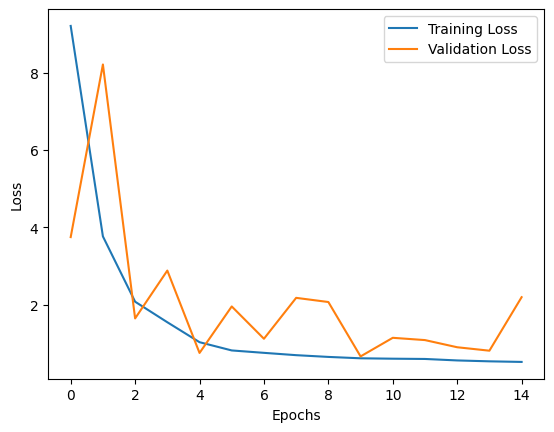

In [ ]:

#  the model
def create_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))  # Dropout layer with a rate of 30%
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

#  image dimensions and number of classes
input_shape = (299, 299, 3)
num_classes = 2  # 'frost' and 'background'

model = create_model(input_shape, num_classes)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#  early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(tf_dataset_train,
                    validation_data=tf_dataset_val,
                    epochs=20,
                    callbacks=[early_stopping])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
y_train_pred_list, y_train_true_list = [], []
y_val_pred_list, y_val_true_list = [], []
y_test_pred_list, y_test_true_list = [], []

# training dataset
for img_batch, label_batch in tf_dataset_train:
    y_train_pred_probs_batch = model.predict(img_batch)
    y_train_pred_batch = np.argmax(y_train_pred_probs_batch, axis=1)

    y_train_pred_list.extend(y_train_pred_batch)
    y_train_true_list.extend(label_batch.numpy())

# val dataset
for img_batch, label_batch in tf_dataset_val:
    y_val_pred_probs_batch = model.predict(img_batch)
    y_val_pred_batch = np.argmax(y_val_pred_probs_batch, axis=1)

    y_val_pred_list.extend(y_val_pred_batch)
    y_val_true_list.extend(label_batch.numpy())

# test dataset
for img_batch, label_batch in tf_dataset_test:
    y_test_pred_probs_batch = model.predict(img_batch)
    y_test_pred_batch = np.argmax(y_test_pred_probs_batch, axis=1)

    y_test_pred_list.extend(y_test_pred_batch)
    y_test_true_list.extend(label_batch.numpy())

y_train_true_binary = np.array(y_train_true_list)
y_val_true_binary = np.array(y_val_true_list)
y_test_true_binary = np.array(y_test_true_list)

precision_train = precision_score(y_train_true_binary, y_train_pred_list)
recall_train = recall_score(y_train_true_binary, y_train_pred_list, zero_division=1)
f1_train = f1_score(y_train_true_binary, y_train_pred_list)

precision_val = precision_score(y_val_true_binary, y_val_pred_list)
recall_val = recall_score(y_val_true_binary, y_val_pred_list, zero_division=1)
f1_val = f1_score(y_val_true_binary, y_val_pred_list)

precision_test = precision_score(y_test_true_binary, y_test_pred_list)
recall_test = recall_score(y_test_true_binary, y_test_pred_list, zero_division=1)
f1_test = f1_score(y_test_true_binary, y_test_pred_list)

# Print metrics for train set
print("Train Set Metrics:")
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_train)

# Print metrics for validation set
print("\nValidation Set Metrics:")
print("Precision:", precision_val)
print("Recall:", recall_val)
print("F1 Score:", f1_val)

# Print metrics for test set
print("\nTest Set Metrics:")
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)

class_report_train = classification_report(y_train_true_binary, y_train_pred_list, target_names=['class_0', 'class_1'])
print("\nClassification Report for Train Set:")
print(class_report_train)

class_report_val = classification_report(y_val_true_binary, y_val_pred_list, target_names=['class_0', 'class_1'])
print("\nClassification Report for Validation Set:")
print(class_report_val)

class_report_test = classification_report(y_test_true_binary, y_test_pred_list, target_names=['class_0', 'class_1'])
print("\nClassification Report for Test Set:")
print(class_report_test)

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


1/1 [==============================] - 0s 33ms/step
Train Set Metrics:
Precision: 0.9738006124532154
Recall: 0.6562714973629902
F1 Score: 0.7841095890410958

Validation Set Metrics:
Precision: 0.7974557246196059
Recall: 0.8802312775330396
F1 Score: 0.8368014657767309

Test Set Metrics:
Precision: 0.9814065077222972
Recall: 0.7787031528851874
F1 Score: 0.8683826456149663

Classification Report for Train Set:
              precision    recall  f1-score   support

     class_0       0.67      0.97      0.79     12235
     class_1       0.97      0.66      0.78     17444

    accuracy                           0.79     29679
   macro avg       0.82      0.82      0.79     29679
weighted avg       0.85      0.79      0.79     29679


Classification Report for Validation Set:
              precision    recall  f1-score   support

     class_0       0.94      0.89      0.92      7654
     class_1       0.80      0.88      0.84      3632

    accuracy                           0.89     11286
 

In [ ]:
def generate_classification_report(model, dataset, target_names):
    y_pred = model.predict(dataset)
    y_pred_binary = (y_pred > 0.5).astype(int)
    y_true = np.concatenate([y.numpy() for _, y in dataset])

    class_report = classification_report(y_true, y_pred_binary, target_names=target_names)

    print("Classification Report:")
    print(class_report)

#### d) Transfer Learning

##### 1) EfficientNet

Epoch 1/20
928/928 [==============================] - 207s 216ms/step - loss: 0.7152 - accuracy: 0.9078 - val_loss: 0.5111 - val_accuracy: 0.8264
Epoch 2/20
928/928 [==============================] - 198s 213ms/step - loss: 0.3088 - accuracy: 0.9178 - val_loss: 0.4894 - val_accuracy: 0.8473
Epoch 3/20
928/928 [==============================] - 195s 209ms/step - loss: 0.2747 - accuracy: 0.9213 - val_loss: 0.4834 - val_accuracy: 0.8387
Epoch 4/20
928/928 [==============================] - 195s 210ms/step - loss: 0.2461 - accuracy: 0.9286 - val_loss: 0.4949 - val_accuracy: 0.8448
Epoch 5/20
928/928 [==============================] - 194s 208ms/step - loss: 0.2223 - accuracy: 0.9349 - val_loss: 0.5208 - val_accuracy: 0.8316
Epoch 6/20
928/928 [==============================] - 193s 208ms/step - loss: 0.2302 - accuracy: 0.9294 - val_loss: 0.5683 - val_accuracy: 0.8346
Epoch 7/20
928/928 [==============================] - 193s 208ms/step - loss: 0.2276 - accuracy: 0.9326 - val_loss: 0.5747 -

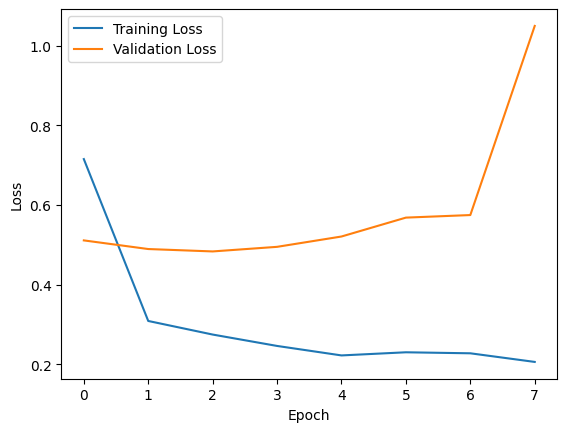

401/401 [==============================] - 56s 140ms/step - loss: 0.2557 - accuracy: 0.9277
Test Accuracy: 92.77%


In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers of the pre-trained EfficientNetB0
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()

model.add(base_model)

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

#  early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping], batch_size=8)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

In [ ]:
generate_classification_report(model, tf_dataset_train, target_names=['class_0', 'class_1'])
print("\nTraining Set Classification Report")

generate_classification_report(model, tf_dataset_val, target_names=['class_0', 'class_1'])
print("\nValidation Set Classification Report")

generate_classification_report(model, tf_dataset_test, target_names=['class_0', 'class_1'])
print("\nTest Set Classification Report")

928/928 [==============================] - 145s 154ms/step
Classification Report:
              precision    recall  f1-score   support

     class_0       0.42      0.40      0.41     12235
     class_1       0.59      0.61      0.60     17444

    accuracy                           0.52     29679
   macro avg       0.50      0.50      0.50     29679
weighted avg       0.52      0.52      0.52     29679


Training Set Classification Report
353/353 [==============================] - 49s 139ms/step
Classification Report:
              precision    recall  f1-score   support

     class_0       0.68      0.54      0.60      7654
     class_1       0.33      0.47      0.39      3632

    accuracy                           0.52     11286
   macro avg       0.51      0.51      0.50     11286
weighted avg       0.57      0.52      0.53     11286


Validation Set Classification Report
401/401 [==============================] - 56s 139ms/step
Classification Report:
              precision    r

##### 2) ResNet

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/20
928/928 [==============================] - 225s 238ms/step - loss: 1.1560 - accuracy: 0.9019 - val_loss: 1.3950 - val_accuracy: 0.6593
Epoch 2/20
928/928 [==============================] - 219s 235ms/step - loss: 0.8562 - accuracy: 0.9076 - val_loss: 1.2422 - val_accuracy: 0.7127
Epoch 3/20
928/928 [==============================] - 217s 234ms/step - loss: 0.7830 - accuracy: 0.9101 - val_loss: 1.6513 - val_accuracy: 0.5595
Epoch 4/20
928/928 [==============================] - 216s 233ms/step - loss: 0.7032 - accuracy: 0.9159 - val_loss: 1.0453 - val_accuracy: 0.7362
Epoch 5/20
928/928 [==============================] - 215s 232ms/step - loss: 0.5580 - accuracy: 0.9188 - val_loss: 0.8184 - val_accuracy: 0.8054
Epoch 6/20
928/928 [==============================] - 217s 233ms/step - loss: 0.4816 - accuracy: 0.9271 - val_loss: 0.4553 - val_accuracy: 0.9216
Epoch 7/20
928/928 [==============================] - 215s 

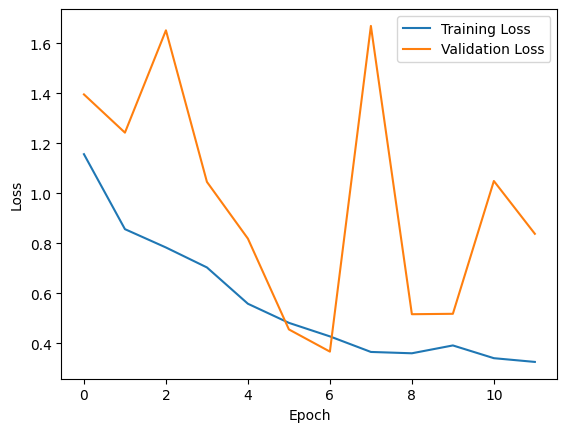

401/401 [==============================] - 64s 158ms/step - loss: 0.3380 - accuracy: 0.9443
Test Accuracy: 94.43%


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers of the pre-trained ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding your custom layers on top of the pre-trained ResNet50
model = models.Sequential()

model.add(base_model)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1, activation='sigmoid'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#  early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping], batch_size=8)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

In [ ]:
generate_classification_report(model, tf_dataset_train, target_names=['class_0', 'class_1'])
print("\nTraining Set Classification Report")

generate_classification_report(model, tf_dataset_val, target_names=['class_0', 'class_1'])
print("\nValidation Set Classification Report")

generate_classification_report(model, tf_dataset_test, target_names=['class_0', 'class_1'])
print("\nTest Set Classification Report")

928/928 [==============================] - 185s 199ms/step
Classification Report:
              precision    recall  f1-score   support

     class_0       0.42      0.26      0.32     12235
     class_1       0.59      0.75      0.66     17444

    accuracy                           0.55     29679
   macro avg       0.50      0.50      0.49     29679
weighted avg       0.52      0.55      0.52     29679


Training Set Classification Report
353/353 [==============================] - 66s 187ms/step
Classification Report:
              precision    recall  f1-score   support

     class_0       0.67      0.24      0.36      7654
     class_1       0.32      0.75      0.45      3632

    accuracy                           0.41     11286
   macro avg       0.50      0.50      0.40     11286
weighted avg       0.56      0.41      0.39     11286


Validation Set Classification Report
401/401 [==============================] - 77s 190ms/step
Classification Report:
              precision    r

##### 3) VGG

Epoch 1/20
928/928 [==============================] - 242s 258ms/step - loss: 0.9633 - accuracy: 0.8846 - val_loss: 3.7076 - val_accuracy: 0.3781
Epoch 2/20
928/928 [==============================] - 243s 261ms/step - loss: 0.8112 - accuracy: 0.8929 - val_loss: 0.8182 - val_accuracy: 0.9034
Epoch 3/20
928/928 [==============================] - 241s 259ms/step - loss: 0.7923 - accuracy: 0.8913 - val_loss: 1.2676 - val_accuracy: 0.6509
Epoch 4/20
928/928 [==============================] - 244s 263ms/step - loss: 0.6827 - accuracy: 0.8968 - val_loss: 0.7586 - val_accuracy: 0.8299
Epoch 5/20
928/928 [==============================] - 244s 263ms/step - loss: 0.6340 - accuracy: 0.9010 - val_loss: 1.0252 - val_accuracy: 0.7462
Epoch 6/20
928/928 [==============================] - 247s 266ms/step - loss: 0.5531 - accuracy: 0.9056 - val_loss: 0.6167 - val_accuracy: 0.8527
Epoch 7/20
928/928 [==============================] - 247s 266ms/step - loss: 0.4846 - accuracy: 0.9100 - val_loss: 0.6957 -

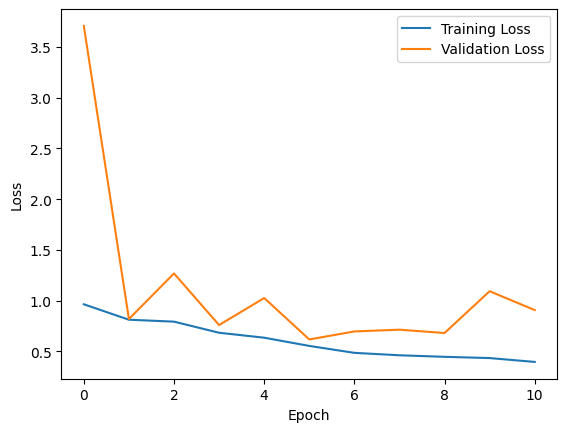

401/401 [==============================] - 73s 181ms/step - loss: 0.4319 - accuracy: 0.9334
Test Accuracy: 93.34%


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers of the pre-trained VGG16
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()

model.add(base_model)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1, activation='sigmoid'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',  # Use binary_crossentropy for binary classification
              metrics=['accuracy'])

#  early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping], batch_size=8)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

In [ ]:
generate_classification_report(model, tf_dataset_train, target_names=['class_0', 'class_1'])
print("\nTraining Set Classification Report")

generate_classification_report(model, tf_dataset_val, target_names=['class_0', 'class_1'])
print("\nValidation Set Classification Report")

generate_classification_report(model, tf_dataset_test, target_names=['class_0', 'class_1'])
print("\nTest Set Classification Report")

928/928 [==============================] - 179s 193ms/step
Classification Report:
              precision    recall  f1-score   support

     class_0       0.41      0.44      0.42     12235
     class_1       0.59      0.57      0.58     17444

    accuracy                           0.51     29679
   macro avg       0.50      0.50      0.50     29679
weighted avg       0.52      0.51      0.51     29679


Training Set Classification Report
353/353 [==============================] - 62s 175ms/step
Classification Report:
              precision    recall  f1-score   support

     class_0       0.68      0.58      0.62      7654
     class_1       0.32      0.43      0.37      3632

    accuracy                           0.53     11286
   macro avg       0.50      0.50      0.50     11286
weighted avg       0.57      0.53      0.54     11286


Validation Set Classification Report
401/401 [==============================] - 70s 175ms/step
Classification Report:
              precision    r

## Comparison

Looking at the classification reports of all the models of transfer learning and CNN + MLP,
Transfer learning models seem to give better results.

The test accuracy for all the three models (EffectiveNet, ResNet, VGG) of transfer learning is way beyond the test accuracy of CNN + MLP.
